<div class="title">Práctica de laboratorio 1: Análisis de Emociones en Novelas Clásicas </div>
<div class="subtitle">Procesamiento del Lenguaje Natural</div>
<div class="author"> Autores:
    <ul>
        <li>Marlon Rodríguez Flor</li>
        <li>Alba Ruiz Vinuesa</li>
    </ul>
</div>

---

### 0. Importación de librerías

In [6]:
import numpy as np
import pandas as pd
import csv
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import requests
from bs4 import BeautifulSoup
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
import plotly.express as px

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1. Load National Research Council

Se realiza la carga del Lexicón a utilizar, en este caso se ha escogido *NRC-Emotion-Lexicon-Wordlevel-v0.92.txt* ya que contiene las emociones de las palabras en inglés.

In [7]:
file_path = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_lexicon = {}
with open(file_path, newline='') as csvfile:
    text = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in text:
        # print(row)
        if int(row[2]) == 1:
            if row[0] not in nrc_lexicon.keys():
                nrc_lexicon[row[0]] = []
            nrc_lexicon[row[0]].append(row[1])

In [39]:
# Vista primeros 5 elementos del diccionario
print('Número de Palabras en Lexicón: {:,}'.format(len(nrc_lexicon.keys())))

print('\nPrimeras 5 palabras con sus emociones asociadas: ')
for k,v in list(nrc_lexicon.items())[:5]:
    print(k, v)

Número de Palabras en Lexicón: 6,453

Primeras 5 palabras con sus emociones asociadas: 
abacus ['trust']
abandon ['fear', 'negative', 'sadness']
abandoned ['anger', 'fear', 'negative', 'sadness']
abandonment ['anger', 'fear', 'negative', 'sadness', 'surprise']
abba ['positive']


### 2. Extender el léxico NRC utilizando WordNet

A continuación, se cargan los los diccionarios que sirven para pasar del POS-tag de wordnet a penn y viceversa.

In [9]:
wordnet_to_penn = {
 'n': 'NN', # sustantivo
 'v': 'VB', # verbo
 'a': 'JJ', # adjetivo
 's': 'JJ', # adjetivo superlativo
 'r': 'RB', # adverbio
 'c': 'CC' # conjunción
}

penn_to_wordnet = {
 'CC': 'c', # Coordinating conjunction
 'CD': 'c', # Cardinal number
 'DT': 'c', # Determiner
 'EX': 'c', # Existential there
 'FW': 'x', # Foreign word
 'IN': 'c', # Preposition or subordinating conjunction
 'JJ': 'a', # Adjective
 'JJR': 'a', # Adjective, comparative
 'JJS': 'a', # Adjective, superlative
 'LS': 'c', # List item marker
 'MD': 'v', # Modal
 'NN': 'n', # Noun, singular or mass
 'NNS': 'n', # Noun, plural
 'NNP': 'n', # Proper noun, singular
 'NNPS': 'n', # Proper noun, plural
  'PDT': 'c', # Predeterminer
 'POS': 'c', # Possessive ending
 'PRP': 'n', # Personal pronoun
 'PRP$': 'n', # Possessive pronoun
 'RB': 'r', # Adverb
 'RBR': 'r', # Adverb, comparative
 'RBS': 'r', # Adverb, superlative
 'RP': 'r', # Particle
 'SYM': 'x', # Symbol
 'TO': 'c', # to
 'UH': 'x', # Interjection
 'VB': 'v', # Verb, base form
 'VBD': 'v', # Verb, past tense
 'VBG': 'v', # Verb, gerund or present participle
 'VBN': 'v', # Verb, past participle
 'VBP': 'v', # Verb, non-3rd person singular present
 'VBZ': 'v', # Verb, 3rd person singular present
 'WDT': 'c', # Wh-determiner
 'WP': 'n', # Wh-pronoun
 'WP$': 'n', # Possessive wh-pronoun
 'WRB': 'r', # Wh-adverb
 'X': 'x' # Any word not categorized by the other tags
 }

Implementamos cirtas funciones que serán útiles para extender el lexicón.

In [33]:
def getSynonyms(word):
    """
    Esta función recibe una palabra y retorna los sinonimos con su respectivo
    POS-tag
    """
    synonyms = wn.synonyms(word)
    # print(synonyms)
    synonyms2 = []
    for sub_array in synonyms:
        if sub_array:
            for element in sub_array:
                synonyms2.append(element)
    # synonyms = [sub_array[0] for sub_array in synonyms if sub_array]
    # print(synonyms2)
    sims = []
    for s in synonyms2:
        for s1 in wn.synsets(s):
            sims.append((s1.name().split('.')[0], s1.pos()))
    return list(set(sims))

print("Ejemplo de la función getSynonyms para la palabra 'Abandon':")
getSynonyms('abandon')

Ejemplo de la función getSynonyms para la palabra 'Abandon':


[('bare', 's'),
 ('empty', 's'),
 ('licentiousness', 'n'),
 ('vacate', 'v'),
 ('empty', 'v'),
 ('lay_waste_to', 'v'),
 ('surrender', 'v'),
 ('wildness', 'n'),
 ('desert', 'v'),
 ('kick', 'v'),
 ('depopulate', 'v'),
 ('abandon', 'v'),
 ('evacuate', 'v'),
 ('forfeit', 'v'),
 ('release', 'v'),
 ('drop_out', 'v'),
 ('desolate', 's'),
 ('empty', 'n'),
 ('discontinue', 'v'),
 ('defect', 'v'),
 ('empty', 'a'),
 ('ferocity', 'n'),
 ('give_up', 'v'),
 ('spare', 'v'),
 ('desert', 'n'),
 ('abandon', 'n'),
 ('revoke', 'v')]

In [34]:
def getHypernyms(word):
    """
    Esta función recibe una palabra y retorna los hiperónimos con su respectivo
    POS-tag
    """
    synsets = wn.synsets(word)
    hypernyms = []
    for synset in synsets:
        for hypernym in synset.hypernyms():
            hypernyms.append((hypernym.name().split('.')[0], hypernym.pos()))
    return list(set(hypernyms))

print("Ejemplo de la función getHypernyms para la palabra 'Abandon':")
getHypernyms('abandon')

Ejemplo de la función getHypernyms para la palabra 'Abandon':


[('leave', 'v'), ('unrestraint', 'n'), ('passion', 'n'), ('discard', 'v')]

In [35]:
def getHyponyms(word):
    """
    Esta función recibe una palabra y retorna los hipónimos con su respectivo
    POS-tag
    """
    synsets = wn.synsets(word)
    hyponyms = []
    for synset in synsets:
        for hyponym in synset.hyponyms():
            hyponyms.append((hyponym.name().split('.')[0], hyponym.pos()))
    return list(set(hyponyms))

print("Ejemplo de la función getHyponyms para la palabra 'Abandon':")
getHyponyms('abandon')

Ejemplo de la función getHyponyms para la palabra 'Abandon':


[('ditch', 'v'),
 ('foreswear', 'v'),
 ('expose', 'v'),
 ('forfeit', 'v'),
 ('walk_out', 'v'),
 ('consign', 'v'),
 ('chuck', 'v'),
 ('dispense_with', 'v'),
 ('maroon', 'v')]

In [36]:
def getDerivedWords(word):
  """
  Esta función recibe una palabra y retorna las palabras derivadas con su
  respectivo POS-tag
  """
  synsets = wn.synsets(word)
  derived_words = []
  for synset in synsets:
      derived_words.append((word, synset.pos()))
      for lemma in synset.lemmas():
          for related_lemma in lemma.derivationally_related_forms():
              derived_words.append((related_lemma.name(), related_lemma.synset().pos()))

  return list(set(derived_words))

print("Ejemplo de la función getDerivedWords para la palabra 'Abandon':")
getDerivedWords('abandon')


Ejemplo de la función getDerivedWords para la palabra 'Abandon':


[('desolation', 'n'),
 ('deserter', 'n'),
 ('desertion', 'n'),
 ('abandonment', 'n'),
 ('abandon', 'v'),
 ('wild', 's'),
 ('wanton', 's'),
 ('vacant', 's'),
 ('abandon', 'n'),
 ('forsaking', 'n')]

A continiación, procedemos a extender el lexicón original utilizando las funciones creadas anteriormente (getSynonyms, getHypernyms, getHyponyms y getDerivedWords). De esta manera, creamos un diccionario en el cual utilizamos como clave la tupla <lemma, POS-tag> con sus respectivas emociones asociadas.

In [37]:
extended_lexicon = {}

for word in list(nrc_lexicon.keys()):
    emotions = nrc_lexicon[word]
    for symnonym in getSynonyms(word):
        if symnonym not in extended_lexicon.keys():
            extended_lexicon[symnonym] = emotions
            
    for hypernym in getHypernyms(word):
        if hypernym not in extended_lexicon.keys():
            extended_lexicon[hypernym] = emotions

    for hyponym in getHyponyms(word):
        if hyponym not in extended_lexicon.keys():
            extended_lexicon[hyponym] = emotions

    for derived_words in getDerivedWords(word):
        if derived_words not in extended_lexicon.keys():
            extended_lexicon[derived_words] = emotions

In [38]:
print('Número de Palabras en Lexicón Extendido: {:,}'.format(len(extended_lexicon)))

print('\nPrimeros 5 elementos del lexicon extendido:')
for key, value in list(extended_lexicon.items())[:5]:
    print(key, value)

Número de Palabras en Lexicón Extendido: 41,119

Primeros 5 elementos del lexicon extendido:
('tablet', 'n') ['trust']
('calculator', 'n') ['trust']
('abacus', 'n') ['trust']
('bare', 's') ['fear', 'negative', 'sadness']
('empty', 's') ['fear', 'negative', 'sadness']


### 3. Cargar el texto de novelas clásicas disponibles en Project Gutenberg

Realizamos la carga de los textos a utilizar.

In [19]:
books = {
 'Moby Dick': 'https://www.gutenberg.org/cache/epub/15/pg15.txt',
 'War and Peace': 'http://www.gutenberg.org/files/2600/2600-0.txt',
 'Pride and Prejudice': 'http://www.gutenberg.org/files/1342/1342-0.txt',
 'Crime and Punishment': 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt',
 'The Adventures of Sherlock Holmes': 'http://www.gutenberg.org/files/1661/1661-0.txt',
 'Ulysses': 'http://www.gutenberg.org/files/4300/4300-0.txt',
 'The Odyssey': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
 'The Divine Comedy': 'https://www.gutenberg.org/cache/epub/8800/pg8800.txt',
 'The Secret Garden': 'https://www.gutenberg.org/cache/epub/17396/pg17396.txt',
 'Critias': 'https://www.gutenberg.org/files/1571/1571-h/1571-h.htm'
}

In [20]:
def download_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text().lower()
    return text

In [21]:
downloaded_books = {}
for book in books:
    downloaded_books[book] = download_text(books[book])

### 4. Implementar una función para analizar el texto y contar las ocurrencias de palabras vinculadas con emociones en el texto

Con el objetivo de realizar un trabajo más limpio y liberar almacenamiento removemos las stop words de los textos y procedemos a realizar la toquenización de los textos.

In [22]:
stop_words = set(stopwords.words('english')) # Stopwords

tokenized_tagget_books = {}
for book in downloaded_books:
    tokenized_tagget_books[book] = pos_tag([word for word in word_tokenize(downloaded_books[book]) if word.isalpha() and not word in stop_words])

In [23]:
print('Primeros 10 a 20 tokens del libro Moby Dick:')
tokenized_tagget_books['Moby Dick'][10:20]

Primeros 10 a 20 tokens del libro Moby Dick:


[('parts', 'NNS'),
 ('world', 'NN'),
 ('cost', 'NN'),
 ('almost', 'RB'),
 ('restrictions', 'NNS'),
 ('whatsoever', 'VBP'),
 ('may', 'MD'),
 ('copy', 'VB'),
 ('give', 'VB'),
 ('away', 'RP')]

Obtenemos el POS-tag de las palbras de los textos y su correspondiente lemma.

In [24]:
lemmatizer = WordNetLemmatizer()

for book in tokenized_tagget_books:
    new_words_tag = []
    for word, tag in tokenized_tagget_books[book]:
        if tag in list(penn_to_wordnet.keys())[:-1]:
            new_words_tag.append((lemmatizer.lemmatize(word), penn_to_wordnet[tag]))
        else:
            new_words_tag.append((lemmatizer.lemmatize(word), penn_to_wordnet['X']))

    tokenized_tagget_books[book] = new_words_tag

In [25]:
print('Primeros 10 a 20 tokens del libro Moby Dick:')
tokenized_tagget_books['Moby Dick'][10:20]

Primeros 10 a 20 tokens del libro Moby Dick:


[('part', 'n'),
 ('world', 'n'),
 ('cost', 'n'),
 ('almost', 'r'),
 ('restriction', 'n'),
 ('whatsoever', 'v'),
 ('may', 'v'),
 ('copy', 'v'),
 ('give', 'v'),
 ('away', 'r')]

Realizamos la comparación de las tuplas con nuestro lexicón y asociamos las emociones correspondientes a cada una de las tuplas.

In [26]:
books_emotions={}
for book in tokenized_tagget_books:
    books_emotions[book] = []
    for wordpos in tokenized_tagget_books[book]:
        if wordpos in extended_lexicon.keys():
            books_emotions[book]+=extended_lexicon[wordpos]

Realizamos el conteo de las emociones y obtenemos los resultados.

In [27]:
words_by_book = []
for book in books_emotions.keys():
    books_emotions[book] = Counter(books_emotions[book])
    words_by_book.append(sum(books_emotions[book].values()))

### 5. Presentar los resultados del análisis de sentimientos en las novelas clásicas.

A continuación, se muestra el número de emociones encontradas en el lexicón extendido para cada uno de los libros. Se puede apreciar que el libro donde se encontró más emociones fue *'War and Peace'* con un total aproximado de 250 mil, segido de *'Ulyses'* y *'Moby Dick'*, con 130 mil y 100 mil, respectivamente. El libro en el que menor cantidad de emociones fue *'Critias'* con solamente 6 mil.

In [28]:
px.bar(pd.DataFrame({'Books':books_emotions.keys(), 'EmotionsNumber':words_by_book}),
       x='Books', y='EmotionsNumber', title="Número de Emociones por Libro", 
       template = "plotly_white")


Además, presentamos el diccionario del conteo de palabras por emoción y para cada uno de los libros.

In [29]:
books_emotions

{'Moby Dick': Counter({'positive': 25407,
          'negative': 18539,
          'trust': 11100,
          'fear': 9299,
          'anticipation': 8174,
          'joy': 6377,
          'sadness': 6279,
          'anger': 5686,
          'disgust': 5121,
          'surprise': 4272}),
 'War and Peace': Counter({'positive': 69489,
          'negative': 37767,
          'trust': 30842,
          'anticipation': 21331,
          'fear': 20326,
          'joy': 17567,
          'sadness': 15148,
          'anger': 12347,
          'surprise': 10301,
          'disgust': 9885}),
 'Pride and Prejudice': Counter({'positive': 15719,
          'trust': 7644,
          'negative': 7442,
          'anticipation': 5666,
          'joy': 4884,
          'fear': 3654,
          'sadness': 3091,
          'surprise': 2615,
          'anger': 2227,
          'disgust': 1929}),
 'Crime and Punishment': Counter({'positive': 22230,
          'negative': 15290,
          'trust': 9982,
          'fear': 75

También, presentamos un gráfico pie que permite ver la proporción de cada una de las emociones, donde se puede apreciar que en todos los textos la emoción principal corresponte a emociones positivas, segido de emociones negativas.

In [30]:
for book in books_emotions.keys():
    emotions = books_emotions[book].keys()
    freq = books_emotions[book].values()
    d = pd.DataFrame({'emotions':emotions, 'freq':freq})
    fig = px.pie(d, values = 'freq', names ='emotions', title = book,
                 color_discrete_sequence=px.colors.colorbrewer.Accent
                 )
    # fig.update_traces(textfont_size=20)
    fig.update_layout(
    autosize=False,
    width=500,
    height=500
)
    fig.show()

Finalmente, presentamos un gráfico de barras que permite apreciar de mejor forma la frecuencia de cada una de las emociones en los distintos textos.

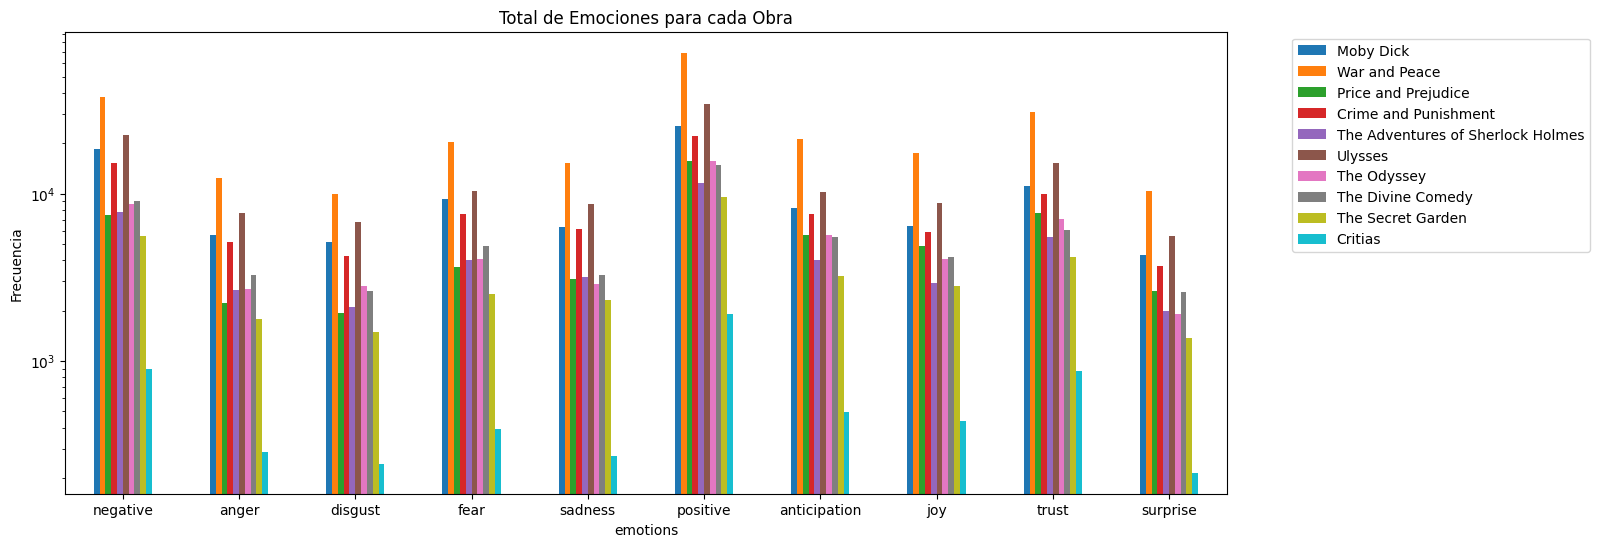

In [31]:
emotions = books_emotions['Moby Dick'].keys()
freq = books_emotions['Moby Dick'].values()
d1 = pd.DataFrame({'emotions':emotions, 'Moby Dick':freq})

emotions = books_emotions['War and Peace'].keys()
freq = books_emotions['War and Peace'].values()
d2 = pd.DataFrame({'emotions':emotions, 'War and Peace':freq})

emotions = books_emotions['Pride and Prejudice'].keys()
freq = books_emotions['Pride and Prejudice'].values()
d3 = pd.DataFrame({'emotions':emotions, 'Price and Prejudice':freq})

emotions = books_emotions['Crime and Punishment'].keys()
freq = books_emotions['Crime and Punishment'].values()
d4 = pd.DataFrame({'emotions':emotions, 'Crime and Punishment':freq})

emotions = books_emotions['The Adventures of Sherlock Holmes'].keys()
freq = books_emotions['The Adventures of Sherlock Holmes'].values()
d5 = pd.DataFrame({'emotions':emotions, 'The Adventures of Sherlock Holmes':freq})

emotions = books_emotions['Ulysses'].keys()
freq = books_emotions['Ulysses'].values()
d6 = pd.DataFrame({'emotions':emotions, 'Ulysses':freq})

emotions = books_emotions['The Odyssey'].keys()
freq = books_emotions['The Odyssey'].values()
d7 = pd.DataFrame({'emotions':emotions, 'The Odyssey':freq})

emotions = books_emotions['The Divine Comedy'].keys()
freq = books_emotions['The Divine Comedy'].values()
d8 = pd.DataFrame({'emotions':emotions, 'The Divine Comedy':freq})

emotions = books_emotions['The Secret Garden'].keys()
freq = books_emotions['The Secret Garden'].values()
d9 = pd.DataFrame({'emotions':emotions, 'The Secret Garden':freq})

emotions = books_emotions['Critias'].keys()
freq = books_emotions['Critias'].values()
d10 = pd.DataFrame({'emotions':emotions, 'Critias':freq})

df = pd.concat([d1.set_index('emotions'), d2.set_index('emotions'), d3.set_index('emotions'), d4.set_index('emotions'), d5.set_index('emotions'), d6.set_index('emotions'), d7.set_index('emotions'), d8.set_index('emotions'), d9.set_index('emotions'), d10.set_index('emotions')], axis=1)

ax = df.plot(kind='bar', logy=True, figsize=(15, 6), rot=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Total de Emociones para cada Obra')
plt.ylabel('Frecuencia')
plt.show()